# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna as opt

# Feature Description

The table results from a query which joins two tables (actuaclly views): "PhotoObj" which contains photometric data and "SpecObj" which contains spectral data.

To ease your start with the data you can read the feature descriptions below:

View "PhotoObj"
objid = Object Identifier
ra = J2000 Right Ascension (r-band)
dec = J2000 Declination (r-band)
Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

run = Run Number
rereun = Rerun Number
camcol = Camera column
field = Field number
Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:

run number, which identifies the specific scan,
the camera column, or "camcol," a number from 1 to 6, identifying the scanline within the run, and
the field number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
An additional number, rerun, specifies how the image was processed.
View "SpecObj"
specobjid = Object Identifier
class = object class (galaxy, star or quasar object)
The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

redshift = Final Redshift
plate = plate number
mjd = MJD of observation
fiberid = fiber ID
In physics, redshift happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum.

Each spectroscopic exposure employs a large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

Modified Julian Date, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding fiberID.

Further information on SDSS images and their attributes:

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php



# Importing the data

In [2]:
# Import the data in ./../data/
df = pd.read_csv("./../data/space.csv")

# Data Exploration

In [3]:
# Use df.head and df.info to get a feel for the data
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


# Categorically Encoding "class"

In [5]:
# Use pandas cat.codes to convert the categorical data to numerical data, this is because xgboost only accepts numerical data as 
# the input in classification problems.
df['class'] = df['class'].astype('category').cat.codes

In [6]:
# Define X and y
X = df.drop(["class"], axis=1)
y = df["class"]

# Train_test_split 

In [7]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna hyperparameter optimalization

In [8]:
#use optuna to tune the hyperparameters
def objective(trial):
    param = {
            "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
            'nthread' : -1
        }
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return score.mean()


study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=2)



[I 2022-10-26 14:03:20,636] A new study created in memory with name: no-name-73b3cbf3-00aa-4c6f-9bda-6877b3363034
[I 2022-10-26 14:03:43,612] Trial 0 finished with value: 0.9773162131395775 and parameters: {'n_estimators': 566, 'max_depth': 11, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.07137160798810045, 'colsample_bytree': 0.39}. Best is trial 0 with value: 0.9773162131395775.
[I 2022-10-26 14:04:59,677] Trial 1 finished with value: 0.9761969607461716 and parameters: {'n_estimators': 863, 'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 2, 'min_child_weight': 0, 'gamma': 3, 'learning_rate': 0.009960784354270901, 'colsample_bytree': 0.31}. Best is trial 0 with value: 0.9773162131395775.


# Using optuna hyperparams to make a model and validate with f1 score

In [9]:
#make a model with the best hyperparameters
model = xgb.XGBClassifier(**study.best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.39,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07137160798810045, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=566, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=4, ...)

# Predicting on the test set with the model

In [10]:
# Predicting on the test set with the model
y_pred = model.predict(X_test)

# Using cross-validation to get an accurate score

In [11]:
# Use cross_val_score to get the cross validation score of the model with the training data.
# Cross validation is a technique to evaluate the performance of a model on unseen data, it is done by splitting the data into "k" folds
# and then training the model on "k-1" folds and testing it on the remaining fold. This is repeated "k" times and the average of the
# scores is taken as the final score. This effectively means that the data is trained and validated on all of the data.
# Run cross_val_score with 5 folds and scoring='f1_macro'

#get f1 score of the model
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')

# Print the mean and standard deviation of the scores, this is a good way to evaluate the performance of the model.
print("F1 score: ", scores.mean())

F1 score:  0.9797587543826831


# Plot the feature importances

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

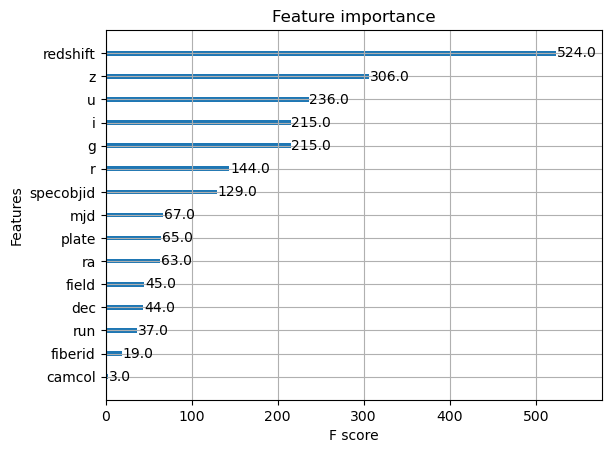

In [12]:
# XGBoost has a built in function to plot the feature importance, use it to plot the feature importance of the model.
# Feature importance shows how much each feature contributes to the model, this is a good way to see which features are important
xgb.plot_importance(model)

# Plotting the confusion matrix

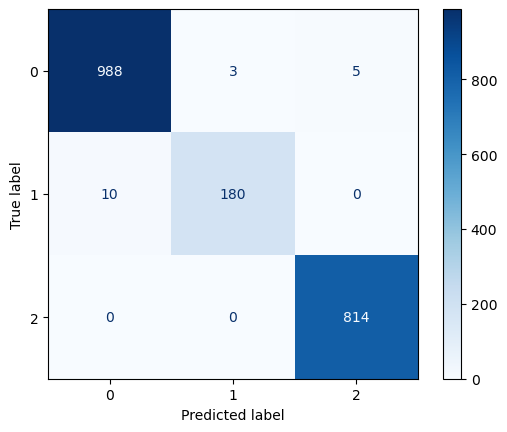

In [13]:
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") 
# on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand,
# but the related terminology can be confusing. The confusion matrix shows the ways in which your classification model is confused
# when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly
# the types of errors that are being made.

# Get the confusion matrix from sklearn.metric.confusion_metric and plot it with ConfusionMatrixDisplay
# Make sure to include display_labels with the class names (HINT: model.classes_) to make the plot more readable

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

# Plot a tree from the model

In [14]:
# XGBoost is a tree based ensemble model, it is always a good idea to visualize the tree to see how the model is making the predictions.
# Use xgb.to_graphviz to visualize the tree and save it as a png file.
xgb.to_graphviz(model, num_trees=0)

ImportError: You must install graphviz to plot tree